
# Bayesian Treatment of Correlated Efficiencies

This notebook complements the frequentist analysis presented in the README by examining the same problem from a Bayesian perspective. 

We consider the same multinomial model for the joint outcomes of two selections A and B, and focus on inference for the efficiency difference $\Delta = p_{10} - p_{01}$.

Rather than validating an uncertainty estimator via repeated sampling, we treat the underlying outcome probabilities $(p_{11}, p_{10}, p_{01}, p_{00})$ as random variables and infer their posterior distribution given observed counts.

---

## Model

We assume:
- A multinomial likelihood for the observed counts
  $$
  (n_{11}, n_{10}, n_{01}, n_{00}) \sim \mathrm{Multinomial}(N, \mathbf{p})
  $$

- A Dirichlet prior on $\mathbf{p}$. We adopt a symmetric $Dirichlet(1,1,1,1)$ prior, corresponding to a uniform prior over joint outcome probabilities. For the large sample sizes considered here, posterior results are insensitive to this choice.


This conjugate choice allows direct sampling from the posterior distribution of $\mathbf{p}$, from which derived quantities such as $\Delta$ can be computed.

---

## Purpose

The aim of this notebook is to:
- obtain the posterior distribution of $\Delta$,
- compare Bayesian credible intervals with the frequentist uncertainty validated previously,
- and verify that both approaches are driven by the same disagreement structure.

This analysis is intended as a consistency check and alternative interpretation, not as a replacement for the frequentist results.

No hypothesis testing or decision rules are imposed; results are reported as posterior summaries.

### What the Bayesian approach adds

Compared to the frequentist treatment, the Bayesian framework provides:
- a full posterior distribution for the efficiency difference $\Delta$,
- direct probability statements such as $P(\Delta>0)$,
- and a natural treatment of small-sample regimes where asymptotic approximations may be unreliable.

For large data samples, the Bayesian posterior width agrees with the frequentist uncertainty derived previously, confirming the consistency of both approaches.



N=1: counts = [1 0 0 0]
- P(Delta > 0) = 0.50085
N=10: counts = [6 2 1 1]
- P(Delta > 0) = 0.68718
N=100: counts = [36 40 19  5]
- P(Delta > 0) = 0.996842
N=1000: counts = [301 387 269  43]
- P(Delta > 0) = 0.999994
N=10000: counts = [2953 3980 2573  494]
- P(Delta > 0) = 1.0
N=100000: counts = [29958 39859 25136  5047]
- P(Delta > 0) = 1.0
N=1000000: counts = [299960 399989 250167  49884]
- P(Delta > 0) = 1.0


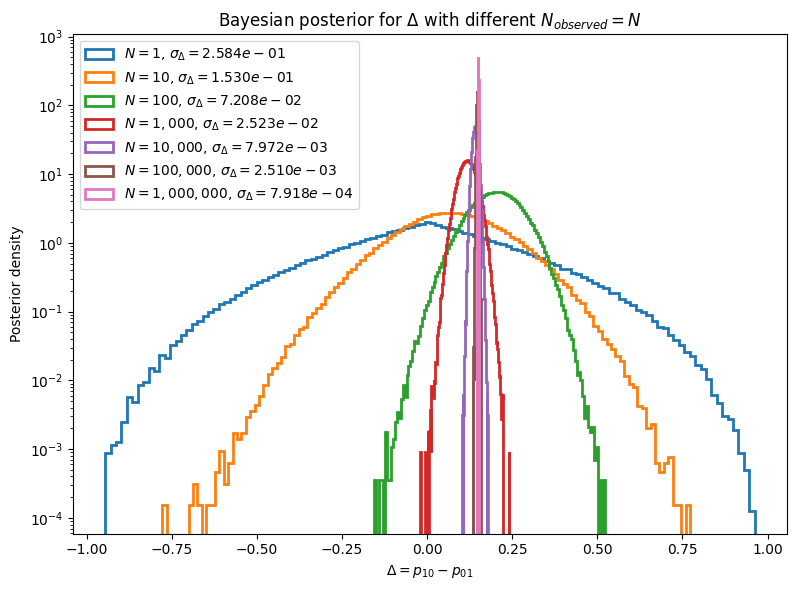

In [5]:
from tools import bayes_delta_posterior

import numpy as np
import matplotlib.pyplot as plt
import yaml

# Load local configuration file
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)


seed = cfg["seed"]

rng = np.random.default_rng(seed)

p = cfg["p_true"]
p_true = np.array([p["p11"], p["p10"], p["p01"], p["p00"]], dtype=float)
Npost=500000
Ns = [1, 10, 100, 1000, 10000, 100000, 1000000]
alpha_prior = np.array(cfg.get("alpha_prior", [1,1,1,1]),dtype=float)

plt.figure(figsize=(8,6))

for N in Ns:
    Delta_samples, info = bayes_delta_posterior(N, p_true, rng, alpha_prior=alpha_prior, Npost=Npost)

    plt.hist(
        Delta_samples,
        bins=120,
        density=True,
        histtype="step",
        linewidth=2,
        label=rf"$N={N:,}$, $\sigma_\Delta={np.std(Delta_samples):.3e}$"
    )
    print(f"N={N}: counts =", info['n'])
    print("- P(Delta > 0) =", np.mean(Delta_samples > 0))

plt.xlabel(r"$\Delta = p_{10} - p_{01}$")
plt.ylabel("Posterior density")
plt.title(r"Bayesian posterior for $\Delta$ with different $N_{{observed}}=N$")
plt.legend()
plt.tight_layout()
plt.yscale("log")
plt.show()


The above plot showed that as the observations increase, the posterior becomes more narrow and centered around the true value. 

### Posterior probability of improvement

From the posterior samples, we compute the probability that method A outperforms method B,

$$P(\Delta > 0 \mid \text{data})$$

As the number of observed events increases, this probability rapidly approaches 1, reflecting increasing certainty that the efficiency of A exceeds that of B. This provides a direct probabilistic statement that is not available in a frequentist hypothesis-testing framework.


One interesting result is obtained when one checks the scaling of $\sigma$ with the $N$ as well as the 68% credible intervals.

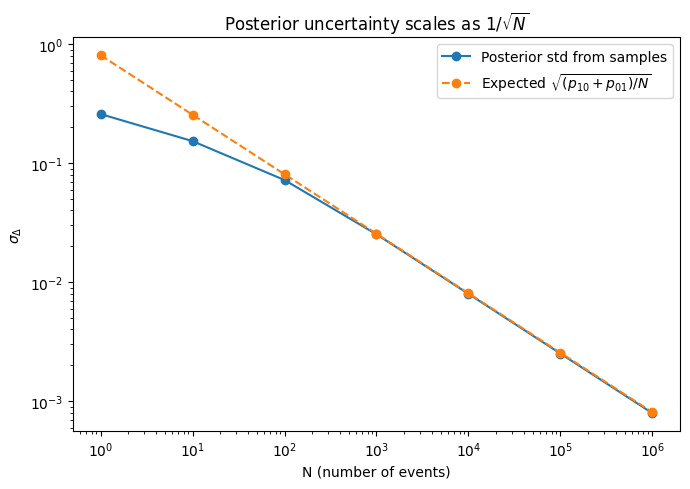

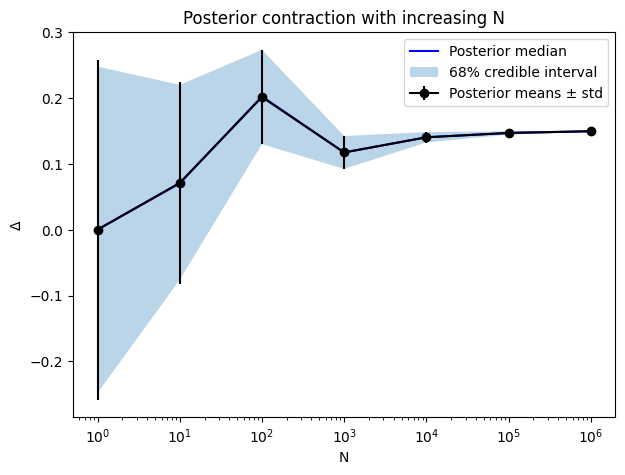

In [6]:
rng = np.random.default_rng(seed)

means, sigmas = [], []
q16s, q50s, q84s = [], [], []

for N in Ns:
    Delta_samples, _ = bayes_delta_posterior(N, p_true, rng, alpha_prior=alpha_prior, Npost=Npost)
    means.append(np.mean(Delta_samples))
    sigmas.append(np.std(Delta_samples))
    q16, q50, q84 = np.quantile(Delta_samples, [0.16, 0.5, 0.84])
    q16s.append(q16)
    q50s.append(q50)
    q84s.append(q84)
sigmas = np.array(sigmas)

plt.figure(figsize=(7,5))
plt.plot(Ns, sigmas, marker="o", label="Posterior std from samples")

# expected scaling ~ sqrt((p10+p01)/N)
p10, p01 = p_true[1], p_true[2]
expected = np.sqrt((p10 + p01) / np.array(Ns))
plt.plot(Ns, expected, marker="o", linestyle="--", label=r"Expected $\sqrt{(p_{10}+p_{01})/N}$")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("N (number of events)")
plt.ylabel(r"$\sigma_\Delta$")
plt.title(r"Posterior uncertainty scales as $1/\sqrt{N}$")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(7,5))
plt.errorbar(Ns, means, yerr=sigmas, linestyle="-", marker="o", color='black', label="Posterior means ± std")
#plt.plot(Ns, means, linestyle="-",marker="o",color='black', label="Posterior means")
plt.plot(Ns, q50s, linestyle="-", color='blue', label="Posterior median")
plt.fill_between(Ns, q16s, q84s, alpha=0.3, label="68% credible interval")
plt.xscale("log")
plt.xlabel("N")
plt.ylabel(r"$\Delta$")
plt.title("Posterior contraction with increasing N")
plt.legend()
plt.show()

And we can derive the statistics for $\Delta$ from its posterior distribution.

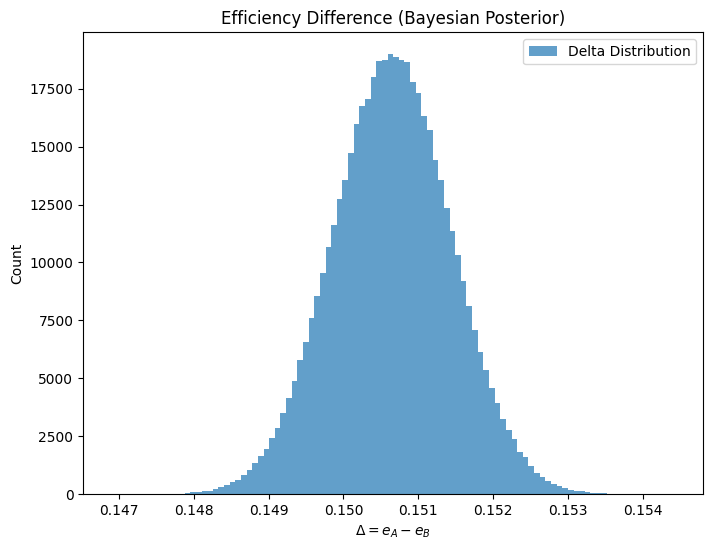

Bayes Method Results:
Delta Mean and Std Dev from Posterior Samples:
Mean: 0.15065135501222068
Std Dev: 0.0007926319530922792
P(Delta > 0) = 1.0
68% credible interval: [0.14986079 0.1514389 ]


In [7]:
rng = np.random.default_rng(seed)
Delta_samples, info = bayes_delta_posterior(N, p_true, rng, alpha_prior=alpha_prior, Npost=Npost)


plt.figure(figsize=(8,6))
plt.hist(Delta_samples, bins=100, histtype='stepfilled', alpha=0.7, label='Delta Distribution')
plt.xlabel(r'$\Delta = e_A - e_B$ ')
plt.ylabel('Count')
plt.legend()
plt.title(rf'Efficiency Difference (Bayesian Posterior)') 
plt.show()

print("Bayes Method Results:")
print("Delta Mean and Std Dev from Posterior Samples:")
print("Mean:", np.mean(Delta_samples))
print("Std Dev:", np.std(Delta_samples))
print("P(Delta > 0) =", np.mean(Delta_samples > 0))
print(f"68% credible interval:", np.quantile(Delta_samples, [0.16, 0.84]))

## Discussion and Conclusions

Using a Dirichlet–multinomial model, we obtained the full posterior distribution of the joint outcome probabilities

$$(p_{11}, p_{10}, p_{01}, p_{00}) \mid (n_{11}, n_{10}, n_{01}, n_{00}),$$

which remains Dirichlet (due to conjugacy).

From this posterior, we derived the induced distribution of the efficiency difference $\Delta = p_{10} - p_{01}$ by direct sampling.

Several observations follow:

- Posterior uncertainty in $\Delta$ is driven entirely by disagreement probabilities $p_{10}$ and $p_{01}$, mirroring the frequentist result that only disagreement events contribute to the variance of $\hat\Delta$.
- Concordant outcomes ($p_{11}$ and $p_{00}$) affect the posterior normalization but do not contribute to the spread of $\Delta$.
- In the large-sample limit, Bayesian credible intervals for $\Delta$ agree with the frequentist uncertainty estimate validated via toy Monte Carlo in the main analysis.

This confirms that the frequentist variance estimator derived previously is consistent with the Bayesian posterior spread under a conjugate prior, and that both frameworks encode the same underlying information structure.

The Bayesian approach provides a complementary interpretation, enabling direct probability statements about $\Delta$ while leaving the core statistical conclusions unchanged. For large samples, the Bayesian posterior standard deviation of $\Delta$ matches the frequentist uncertainty $\sigma_{{Correct}}$ derived previously, confirming that both approaches encode the same information in different languages.

### Bayesian vs Frequentist comparison (single dataset)

The table above summarizes a direct comparison between the frequentist and Bayesian treatments
of the efficiency difference $\Delta = e_A - e_B = p_{10} - p_{01}$, using the **same observed counts** $(n_{11}, n_{10}, n_{01}, n_{00})$ for both approaches.

For each value of $N$, we report:

**Observed data**
- $n_{11}, n_{10}, n_{01}, n_{00}$: event counts from a multinomial model

**Frequentist quantities**
- $\hat{\Delta} = (n_{10} - n_{01}) / N$: estimator of the efficiency difference  
- $\sigma_{Correct} = \sqrt{(n_{10}+n_{01})}/N$: correct uncertainty accounting for correlations  
- $Z = \hat{\Delta}/\sigma_{Correct}$: test statistic  
- One-sided and two-sided *p*-values for the null hypothesis $\Delta = 0$

**Bayesian quantities**
- Posterior mean and standard deviation of $\Delta$  
- Posterior median  
- 68% and 95% credible intervals  
- $P(\Delta > 0 \mid \text{data})$: posterior probability that method A outperforms method B  

For large sample sizes, the Bayesian posterior standard deviation agrees with the frequentist
$\sigma_{Correct}$, and the posterior becomes approximately Gaussian. In this regime,
both approaches encode the same information, expressed in different statistical languages.

The Bayesian framework additionally allows direct probability statements about $\Delta$,
such as $P(\Delta > 0)$, which have no direct frequentist analogue.


In [9]:
import pandas as pd
from scipy.stats import norm

def make_comparison_table(Ns, p_true, rng, alpha_prior=None, Npost=200000):
    if alpha_prior is None:
        alpha_prior = np.ones(4)

    rows = []
    p_true = np.asarray(p_true, dtype=float)

    for N in Ns:
        # "Observed" data (toy dataset)
        n11, n10, n01, n00 = rng.multinomial(N, p_true)

        # Frequentist quantities
        Delta_hat = (n10 - n01) / N
        sigma_corr = np.sqrt((n10 + n01) / (N**2))

        Z = Delta_hat / sigma_corr if sigma_corr > 0 else np.nan
        p_one_sided = 1 - norm.cdf(Z) if np.isfinite(Z) else np.nan
        p_two_sided = 2 * (1 - norm.cdf(abs(Z))) if np.isfinite(Z) else np.nan

        # Bayesian posterior
        alpha_post = alpha_prior + np.array([n11, n10, n01, n00], dtype=float)
        p_samp = rng.dirichlet(alpha_post, size=Npost)
        Delta_post = p_samp[:, 1] - p_samp[:, 2]

        post_mean = float(np.mean(Delta_post))
        post_std  = float(np.std(Delta_post))
        q16, q50, q84 = np.quantile(Delta_post, [0.16, 0.5, 0.84])
        q025, q975 = np.quantile(Delta_post, [0.025, 0.975])
        prob_gt0 = float(np.mean(Delta_post > 0))

        rows.append({
            "N": N,
            "n11": int(n11), "n10": int(n10), "n01": int(n01), "n00": int(n00),
            "Delta_hat": Delta_hat,
            "sigma_corr": sigma_corr,
            "Z": Z,
            "p_one_sided(H0:Δ=0)": p_one_sided,
            "p_two_sided(H0:Δ=0)": p_two_sided,
            "Bayes_mean(Δ)": post_mean,
            "Bayes_std(Δ)": post_std,
            "Bayes_CI68_low": float(q16),
            "Bayes_median": float(q50),
            "Bayes_CI68_high": float(q84),
            "Bayes_CI95_low": float(q025),
            "Bayes_CI95_high": float(q975),
            "Bayes_P(Δ>0)": prob_gt0,
        })

    df = pd.DataFrame(rows)
    return df

seed = cfg["seed"]
rng = np.random.default_rng(seed)

Ns = [10, 100, 1000, 10000, 100000]

df = make_comparison_table(Ns, p_true, rng, alpha_prior=alpha_prior, Npost=Npost)
df

,N,n11,n10,n01,n00,Delta_hat,sigma_corr,Z,p_one_sided(H0:Δ=0),p_two_sided(H0:Δ=0),Bayes_mean(Δ),Bayes_std(Δ),Bayes_CI68_low,Bayes_median,Bayes_CI68_high,Bayes_CI95_low,Bayes_CI95_high,Bayes_P(Δ>0)
0,10,6,2,2,0,0.0000,0.200000,0.000000,0.500000,1.000000,-0.000265,0.169051,-0.166391,-0.000162,0.165294,-0.335643,0.334982,0.499610
1,100,35,37,24,4,0.1300,0.078102,1.664479,0.048008,0.096017,0.124901,0.074864,0.050264,0.125346,0.199555,-0.022668,0.270438,0.951524
2,1000,307,383,264,46,0.1190,0.025436,4.678373,0.000001,0.000003,0.118512,0.025026,0.093672,0.118579,0.143426,0.069326,0.167361,0.999998
3,10000,3021,3954,2530,495,0.1424,0.008052,17.684325,0.000000,0.000000,0.142363,0.007910,0.134503,0.142353,0.150235,0.126865,0.157883,1.000000
4,100000,29920,40150,24890,5040,0.1526,0.002550,59.836236,0.000000,0.000000,0.152589,0.002507,0.150103,0.152589,0.155077,0.147669,0.157509,1.000000
